In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, regularizers, models, layers, callbacks
from sklearn.utils import class_weight

from prosenet import ProSeNet, PrototypeProjection, datasets, ops

In [2]:
# Dataset parameters
num_classes = 5
sequence_length = 187

In [3]:
# Set any non-default args
new_rnn_args = {
    'layers' : [32, 32, 32],
    'layer_args' : {
        'dropout' : 0.1,
        'activity_regularizer' : regularizers.l2(0.1)    # Note: not in paper
    }
}

new_proto_args = {
    'dmin' : 2.0,
    'Ld' : 0.01, #0.1,
    'Lc' : 0.0,
    'Le' : 1.0
}

pnet = ProSeNet(input_shape=(sequence_length, 1), 
                nclasses=num_classes, 
                k=30, 
                rnn_args=new_rnn_args,
                prototypes_args=new_proto_args,
                L1=0.1)

# Need to build for summary
pnet.build( (None, 187, 1) )

pnet.summary()

Model: "pro_se_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64)                58368     
_________________________________________________________________
prototypes (Prototypes)      multiple                  1920      
_________________________________________________________________
classifier (Dense)           multiple                  150       
Total params: 60,438
Trainable params: 60,438
Non-trainable params: 0
_________________________________________________________________


In [4]:
data = datasets.ArrhythmiaDataset('../data/', normalize=False)
print(data)

MIT-BIH Arrhythmia Dataset
Num classes: 5
Input shape: (187, 1)
Train, Test counts: 87554, 21892



In [5]:
train_gen = datasets.DataGenerator(data.X_train, data.y_train, batch_size=128)

test_gen = datasets.DataGenerator(data.X_test, data.y_test, batch_size=128)

class_weights = 1 - (np.bincount(np.argmax(data.y_train, 1)) / data.y_train.shape[0])

#class_weights[0] = 0.01
class_weights

array([0.17227083, 0.97460995, 0.93389223, 0.9926788 , 0.92654819])

# First train just the `encoder`

In [6]:
pnet.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 187, 64)           8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 187, 64)           24832     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
Total params: 58,368
Trainable params: 58,368
Non-trainable params: 0
_________________________________________________________________


In [7]:
x_encoded = pnet.encoder.output

pred = layers.Dense(num_classes, activation='softmax')(x_encoded)

encoder_classifier = models.Model(inputs=pnet.encoder.input, outputs=pred)

encoder_classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 187, 64)           8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 187, 64)           24832     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 58,693
Trainable params: 58,693
Non-trainable params: 0
_________________________________________________________________


In [8]:
rms = optimizers.RMSprop()

encoder_classifier.trainable = True

encoder_classifier.compile(optimizer=rms, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(patience=3)

encoder_classifier.fit_generator(train_gen, 
                   validation_data=test_gen, 
                   epochs=10,
                   callbacks=[early_stopping],
                   class_weight=class_weights,
                   shuffle=False)

Epoch 1/10
685/685 [==============================] - 71s 104ms/step - loss: 1.0134 - accuracy: 0.8306 - val_loss: 0.7472 - val_accuracy: 0.8699
Epoch 2/10
685/685 [==============================] - 69s 101ms/step - loss: 0.4896 - accuracy: 0.8818 - val_loss: 0.4513 - val_accuracy: 0.8932
Epoch 3/10
685/685 [==============================] - 70s 101ms/step - loss: 0.4203 - accuracy: 0.9011 - val_loss: 0.3691 - val_accuracy: 0.9183
Epoch 4/10
685/685 [==============================] - 71s 103ms/step - loss: 0.3589 - accuracy: 0.9211 - val_loss: 0.3382 - val_accuracy: 0.9252
Epoch 5/10
685/685 [==============================] - 74s 107ms/step - loss: 0.3096 - accuracy: 0.9334 - val_loss: 0.4419 - val_accuracy: 0.8948
Epoch 6/10
685/685 [==============================] - 71s 104ms/step - loss: 0.2846 - accuracy: 0.9381 - val_loss: 0.3086 - val_accuracy: 0.9397
Epoch 7/10
685/685 [==============================] - 72s 104ms/step - loss: 0.2686 - accuracy: 0.9419 - val_loss: 0.2470 - val_ac

# Now freeze the `encoder` and train the prototypes head

In [9]:
# Freeze the encoder
pnet.encoder.trainable = False

In [10]:
# Define come `Callback`s

# 1.0 seems pretty high... but we'll follow the paper.
init_lr = 1.0 # 0.1 # 1.0

def lr_schedule(epoch):
    if epoch <= 10:
        return init_lr
    else:
        return init_lr * 0.85**(epoch - 10)
    
lr_schedule = callbacks.LearningRateScheduler(lr_schedule)

early_stopping = callbacks.EarlyStopping(patience=3)

projection = PrototypeProjection(train_gen, freq=4)

In [11]:
sgd = optimizers.SGD(learning_rate=init_lr, clipnorm=5.0)

pnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

pnet.fit_generator(train_gen, 
                   validation_data=test_gen, 
                   epochs=26,
                   callbacks=[early_stopping, lr_schedule, projection],
                   class_weight=class_weights,
                   shuffle=False)

Epoch 1/26
684/685 [============================>.] - ETA: 0s - loss: 595.5198 - accuracy: 0.8229
Computing prototype projection...
... assigned new prototypes from projections.
685/685 [==============================] - 95s 139ms/step - loss: 594.6771 - accuracy: 0.8230 - val_loss: 1.6393 - val_accuracy: 0.8276
Epoch 2/26
685/685 [==============================] - 70s 102ms/step - loss: 585.1420 - accuracy: 0.8281 - val_loss: 1.6394 - val_accuracy: 0.0254
Epoch 3/26
685/685 [==============================] - 70s 102ms/step - loss: 599.1349 - accuracy: 0.8203 - val_loss: 1.6419 - val_accuracy: 0.0735
Epoch 4/26
685/685 [==============================] - 71s 103ms/step - loss: 613.6490 - accuracy: 0.8203 - val_loss: 1.6340 - val_accuracy: 0.8276
Epoch 5/26
684/685 [============================>.] - ETA: 0s - loss: 613.8984 - accuracy: 0.8281
Computing prototype projection...
... assigned new prototypes from projections.
685/685 [==============================] - 92s 135ms/step - loss: 6

# Diagnostics

-1.0 1.0


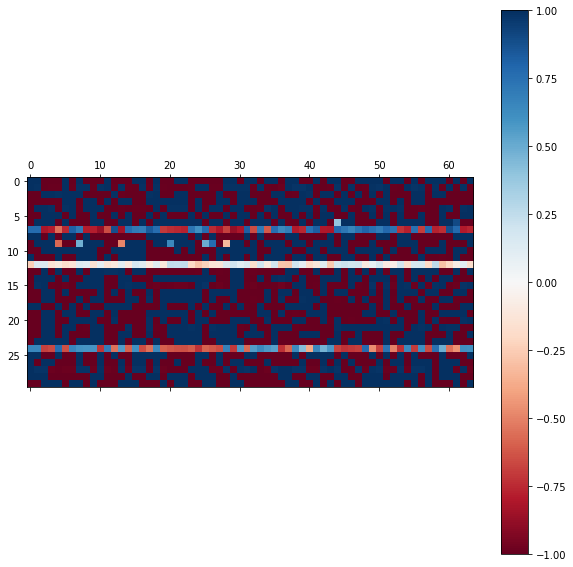

In [12]:
# Prototype layer weights
protos = np.squeeze(pnet.prototypes_layer.weights[0].numpy())
print(protos.min(), protos.max())

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(protos, cmap=plt.cm.RdBu)
fig.colorbar(cax, ax=ax)

0.0 0.09715751


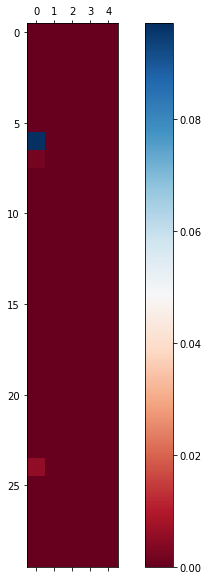

In [13]:
pred_weights = np.squeeze(pnet.classifier.weights[0].numpy())
print(pred_weights.min(), pred_weights.max())

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(pred_weights, cmap=plt.cm.RdBu)
fig.colorbar(cax, ax=ax)

In [28]:
X_encoded = pnet.encoder.predict_generator(train_gen)

In [30]:
X_encoded = tf.expand_dims(tf.convert_to_tensor(X_encoded), -2)

#distance matrix from protos
protos = pnet.prototypes_layer.weights[0]
d2 = tf.norm(X_encoded - protos, ord=2, axis=-1)

idxs = tf.argmin(d2, axis=0).numpy()
idxs

array([[39118, 24683, 77248, 46176, 77158, 48933,  8424, 32659, 70694,
        60194, 14198, 17439,  5416, 46257, 61322, 27311, 61322, 52261,
           11,  5020, 21998, 13700, 13700, 62366, 61715,  6636, 81196,
        49565, 66530,  6636]])

In [31]:
matched_protos = train_gen.X[np.squeeze(idxs)]
matched_protos.shape

(30, 187, 1)

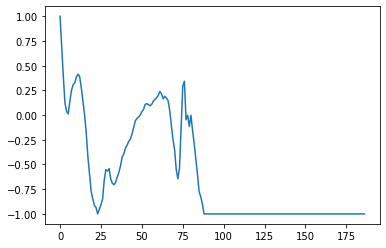

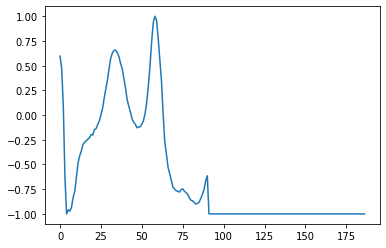

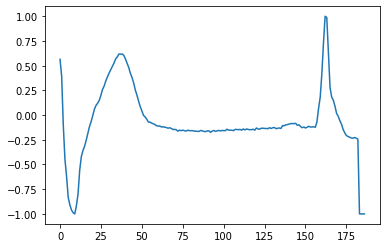

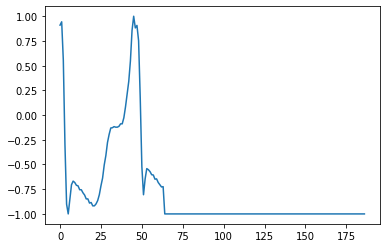

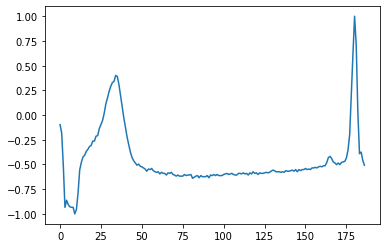

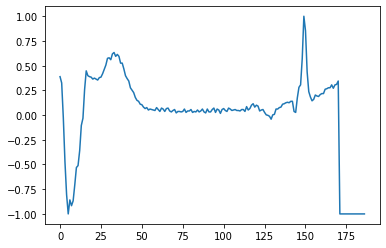

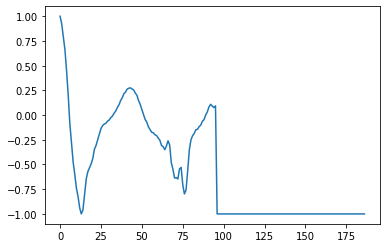

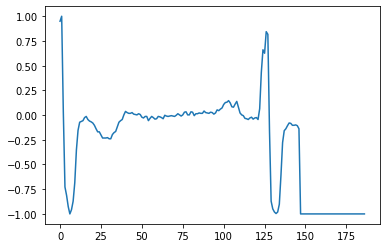

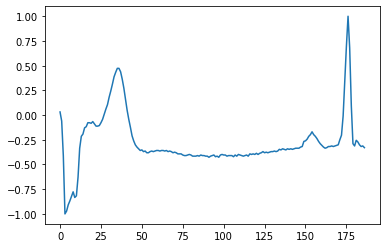

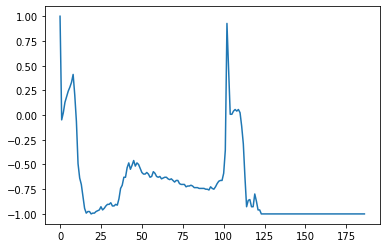

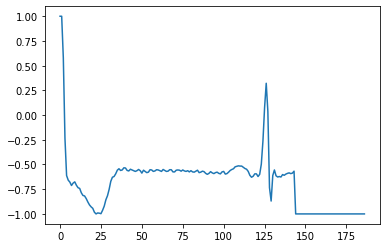

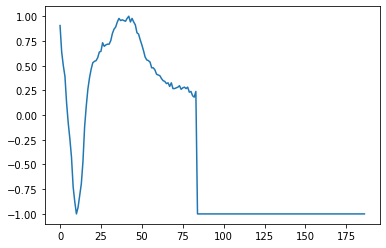

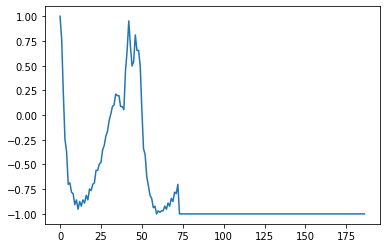

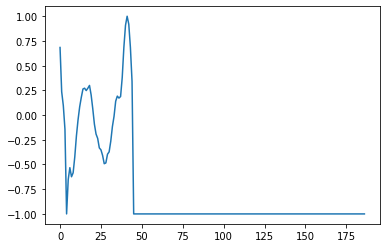

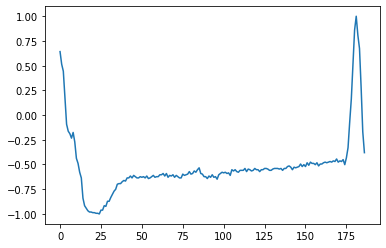

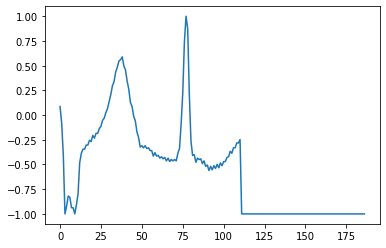

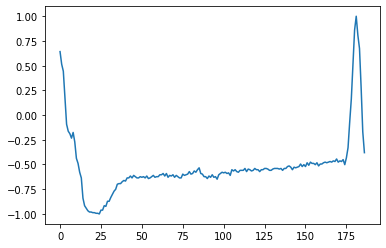

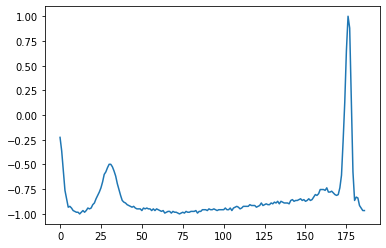

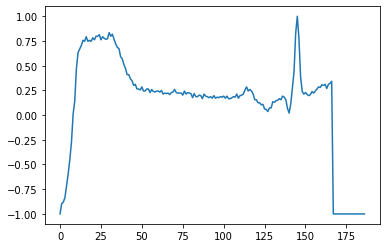

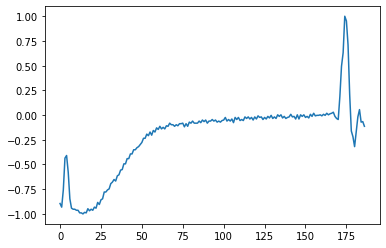

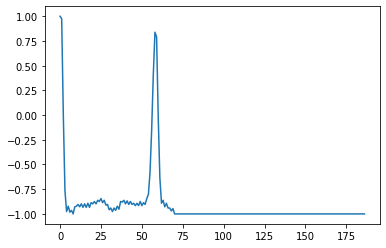

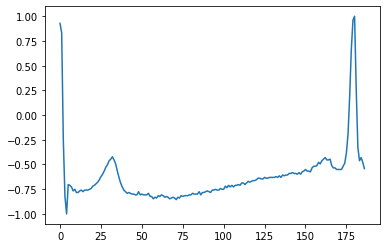

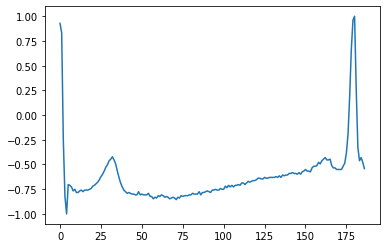

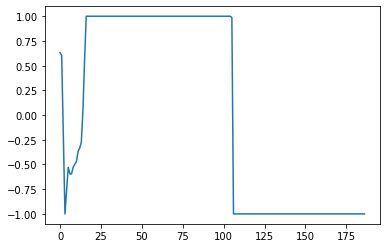

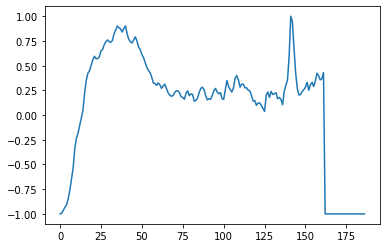

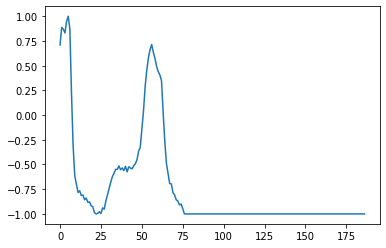

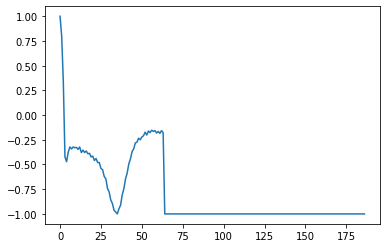

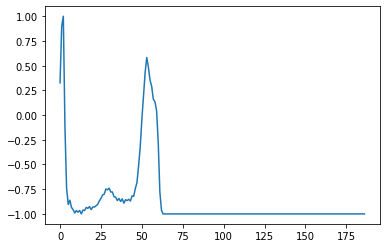

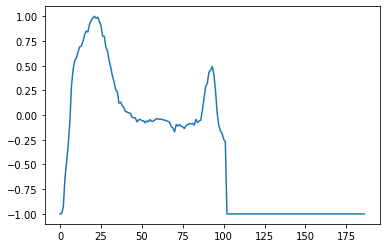

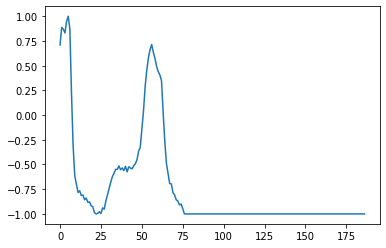

In [32]:
for i in range(30):
    plt.plot(np.arange(187), matched_protos[i,:,0])
    plt.show()

In [16]:
pnet.predict(data.X_test[-3:,:], batch_size=1)

array([[0.20001195, 0.19999702, 0.19999702, 0.19999702, 0.19999702],
       [0.2000131 , 0.19999672, 0.19999672, 0.19999672, 0.19999672],
       [0.20001297, 0.19999674, 0.19999674, 0.19999674, 0.19999674]],
      dtype=float32)

In [17]:
data.y_test[-3:]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

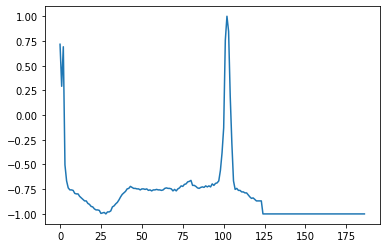

In [18]:
plt.plot(np.arange(187), data.X_train[-2])

In [19]:
class_weights

array([0.17227083, 0.97460995, 0.93389223, 0.9926788 , 0.92654819])

In [20]:
pnet.classifier.weights[0].numpy()

array([[0.00028228, 0.        , 0.        , 0.        , 0.        ],
       [0.0002942 , 0.        , 0.        , 0.        , 0.        ],
       [0.00025123, 0.        , 0.        , 0.        , 0.        ],
       [0.00025802, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.09715751, 0.        , 0.        , 0.        , 0.        ],
       [0.00207292, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.0002409 , 0.        , 0.

In [21]:
encoder_classifier.layers[-1].weights

[<tf.Variable 'dense/kernel:0' shape=(64, 5) dtype=float32, numpy=
 array([[ 1.0934138 , -1.1192349 , -0.71671337, -1.5306606 , -0.2007867 ],
        [ 1.2871476 , -1.071761  , -0.66414905, -1.9553947 , -0.09394386],
        [-1.431489  ,  0.7919457 , -0.08302482,  0.36912414,  2.191277  ],
        [-1.4131911 ,  1.9056269 ,  0.46712622,  0.48845366,  0.2746533 ],
        [ 1.3730251 , -1.5870554 ,  0.27679938, -0.8956855 , -2.504709  ],
        [-1.2142026 ,  1.0393384 ,  0.5746028 ,  0.07849234,  1.5820637 ],
        [-1.3255124 ,  0.5914491 ,  1.0867101 ,  1.7546799 ,  0.65479976],
        [ 1.2089511 , -0.9960997 , -0.8405281 , -1.6184723 ,  0.6694317 ],
        [-0.9502766 ,  0.5924782 , -0.47650948,  1.6964821 ,  1.8132993 ],
        [-1.2298707 , -0.03646556,  0.10263666,  2.5270615 ,  1.2544913 ],
        [-1.3250167 ,  1.5754836 , -0.11702115,  0.26348603,  2.0608418 ],
        [ 1.4271479 , -0.8245496 ,  0.20949668, -0.27438927, -2.0745163 ],
        [ 1.0438685 , -0.5199557 

In [22]:
protos = np.squeeze(pnet.prototypes_layer.weights[0].numpy())
protos

array([[ 0.9999984 ,  0.9999984 , -0.9999984 , ...,  0.99999845,
        -0.9999984 ,  0.9999983 ],
       [ 1.        ,  0.9853272 , -1.        , ..., -0.9852008 ,
         0.98632306, -0.98452455],
       [-0.9983835 , -0.9960215 ,  1.        , ..., -1.        ,
        -1.        , -0.99890023],
       ...,
       [ 1.        ,  0.9835244 ,  0.98095876, ..., -0.9836826 ,
         0.9847518 , -0.9822949 ],
       [ 0.9995374 ,  0.99995697,  1.        , ...,  0.99804914,
        -1.        , -0.999202  ],
       [-1.        , -1.        ,  1.        , ...,  0.9988618 ,
        -1.        ,  1.        ]], dtype=float32)

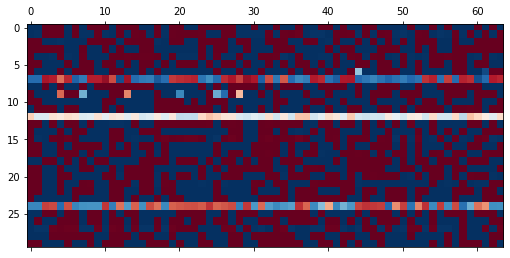

In [23]:
plt.matshow(protos, cmap=plt.cm.RdBu)

In [24]:
pnet.encoder.predict(data.X_train[-2:,:])

array([[ 0.0095011 ,  0.01693661, -0.01654375, -0.01257223,  0.02154281,
        -0.00243336, -0.00985718, -0.00323537, -0.01578237, -0.01407533,
        -0.02243105,  0.01398361,  0.02834626, -0.02508484,  0.00841356,
        -0.00040875,  0.00059869,  0.0245306 ,  0.01108403,  0.01986117,
        -0.00421485, -0.01062258, -0.01129108, -0.0024553 , -0.02060771,
         0.00571094, -0.00176065, -0.01447801,  0.00777767, -0.02086783,
        -0.0169794 ,  0.01734797,  0.03789744,  0.00530081,  0.14682391,
         0.02494797, -0.0167122 , -0.04803029, -0.07465099,  0.02620873,
        -0.00776494,  0.01089203,  0.0368707 , -0.05542944,  0.05669463,
         0.03243364, -0.06092099,  0.02238571, -0.01960111, -0.04931808,
         0.01625356, -0.08889644, -0.03106137,  0.01747476, -0.03097953,
         0.01627013,  0.0248491 ,  0.00984802, -0.01020246,  0.02352631,
         0.08838965,  0.01946665,  0.01566147, -0.05771298],
       [ 0.01060492,  0.01817613, -0.01478582, -0.01577278,  0.

In [25]:
pnet.encoder.predict(data.X_train[:2,:])

array([[ 7.70711107e-03,  1.28560355e-02, -2.47689933e-02,
        -7.72093702e-03,  2.33375784e-02, -9.88993328e-03,
        -1.49060320e-02, -3.83846788e-03, -1.79799143e-02,
        -1.95809230e-02, -2.38883533e-02,  2.29306724e-02,
         2.86456961e-02, -2.35608015e-02,  2.79676523e-02,
         1.40943006e-03,  9.64278448e-03,  2.73868609e-02,
        -5.28266501e-05,  2.16954555e-02, -7.44769536e-03,
        -1.08342208e-02, -1.00057321e-02,  2.46141069e-02,
        -2.99127735e-02,  1.99853852e-02, -7.23390200e-04,
         2.94397166e-03,  2.74808444e-02, -2.16021053e-02,
        -2.24106740e-02,  2.23939754e-02,  6.58136234e-02,
        -6.86751213e-03,  9.04086903e-02,  3.52394991e-02,
        -4.98656034e-02, -6.90167248e-02, -6.49838522e-03,
        -9.88586154e-03, -6.05113283e-02,  5.74022867e-02,
        -3.26908613e-03, -5.89719787e-02,  9.21004787e-02,
         3.61705422e-02, -5.95938647e-03,  3.37797925e-02,
        -9.91088711e-03, -8.67809653e-02,  8.88273343e-0

In [26]:
pnet.prototypes_layer._diversity_term()

<tf.Tensor: id=26780878, shape=(), dtype=float32, numpy=7.0256987>

In [27]:
pnet.losses

[<tf.Tensor 'pro_se_net/sequential/bidirectional/forward_lstm0/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/sequential/bidirectional/backward_lstm0/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/sequential/bidirectional_1/forward_lstm1/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/sequential/bidirectional_1/backward_lstm1/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/sequential/bidirectional_2/forward_lstm2/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/sequential/bidirectional_2/backward_lstm2/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/prototypes/Const:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/prototypes/Const_1:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/prototypes/Const_2:0' shape=() dtype=float32>,
 <tf.Tensor: id=26780886, shape=(), dtype=float32, numpy=0.01083